In [1]:
# =========================
# CELL 0: COMMON SETUP
# =========================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

# Scaling
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Create sequences
#Use the previous 60 days of stock prices to predict the price of the next day



X_train, y_train = [], []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0]) #Index: 0 → 59   → used as input
    y_train.append(training_set_scaled[i, 0]) #Index: 60       → predicted value

X_train = np.array(X_train)
y_train = np.array(y_train)

# Dataset class
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [2]:
# =========================
# CELL 2: LSTM
# =========================
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50,
                            num_layers=4, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 100
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.067893
Epoch 1, Loss: 0.013547
Epoch 2, Loss: 0.007049
Epoch 3, Loss: 0.002739
Epoch 4, Loss: 0.002985
Epoch 5, Loss: 0.003192
Epoch 6, Loss: 0.007066
Epoch 7, Loss: 0.003506
Epoch 8, Loss: 0.002827
Epoch 9, Loss: 0.001811
Epoch 10, Loss: 0.001201
Epoch 11, Loss: 0.001112
Epoch 12, Loss: 0.002689
Epoch 13, Loss: 0.003297
Epoch 14, Loss: 0.001928
Epoch 15, Loss: 0.001668
Epoch 16, Loss: 0.000881
Epoch 17, Loss: 0.003351
Epoch 18, Loss: 0.001551
Epoch 19, Loss: 0.007347
Epoch 20, Loss: 0.001192
Epoch 21, Loss: 0.001380
Epoch 22, Loss: 0.000733
Epoch 23, Loss: 0.001017
Epoch 24, Loss: 0.001251
Epoch 25, Loss: 0.000653
Epoch 26, Loss: 0.001073
Epoch 27, Loss: 0.000877
Epoch 28, Loss: 0.001979
Epoch 29, Loss: 0.002329
Epoch 30, Loss: 0.000716
Epoch 31, Loss: 0.003419
Epoch 32, Loss: 0.000589
Epoch 33, Loss: 0.000550
Epoch 34, Loss: 0.001225
Epoch 35, Loss: 0.001147
Epoch 36, Loss: 0.000563
Epoch 37, Loss: 0.001106
Epoch 38, Loss: 0.001058
Epoch 39, Loss: 0.001317
Epoch 40, 

In [3]:
# =========================
# EVALUATION: TEST SET
# =========================

# Load test data
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Combine train + test for sequence creation
dataset_total = pd.concat(
    (dataset_train['Open'], dataset_test['Open']), axis=0
).values.reshape(-1, 1)

# Scale
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:]
inputs = sc.transform(inputs)

# Create test sequences
X_test = []
for i in range(60, 60 + len(dataset_test)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Prediction
model.eval()
with torch.no_grad():
    predicted_stock_price = model(X_test).cpu().numpy()

# Inverse scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [4]:
import pandas as pd

# After predicting stock prices:

# Create a DataFrame with both real and predicted prices
df_comparison = pd.DataFrame({'Real Stock Price': real_stock_price.reshape(len(real_stock_price)),
                             'Predicted Stock Price': predicted_stock_price.reshape(len(predicted_stock_price))})

# Display the DataFrame
print(df_comparison)

    Real Stock Price  Predicted Stock Price
0             778.81             800.685486
1             788.36             798.874634
2             786.08             799.855225
3             795.26             800.591187
4             806.40             802.616455
5             807.86             806.387634
6             805.00             808.991150
7             807.14             809.455872
8             807.48             809.896545
9             807.08             810.561401
10            805.81             811.125488
11            805.12             811.369751
12            806.91             811.479492
13            807.25             811.992798
14            822.30             812.497681
15            829.62             815.595947
16            837.81             818.996338
17            834.71             821.909729
18            814.66             822.690369
19            796.86             819.546448


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)

print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")


RMSE : 10.871
MAE  : 8.800
R²   : 0.456


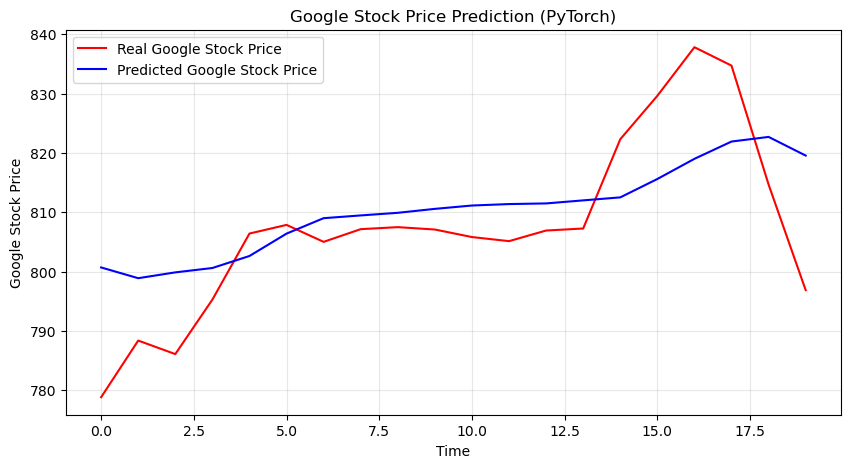

In [6]:
# =========================
# VISUALIZATION
# =========================
plt.figure(figsize=(10,5))
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction (PyTorch)')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
